# Kili Tutorial: Import/export pixel-level masks in Kili Technology

In this tutorial, we will show you how to import/export pixel-level masks when doing [semantic annotation in Kili Technology](https://cloud.kili-technology.com/docs/image-interfaces/segmentation). Such projects allow you to annotate image data at pixel level.

The data we use comes from [COCO dataset](https://cocodataset.org).

## Load an image from COCO dataset to Kili Technology

Let's first inspect what an annotated image looks like in COCO dataset.

<img src="http://farm7.staticflickr.com/6153/6181981748_6a225c275d_z.jpg">

You can go to [this URL](http://cocodataset.org/#explore?id=219921) to see it annotated.

Let's create a project in Kili Technology where we can annotate images with two classes: `HUMAN` and `MOTORCYCLE` at pixel level.

In [1]:
json_interface = {
	"jobs": {
		"JOB_0": {
			"mlTask": "OBJECT_DETECTION",
			"tools": [
				"semantic"
			],
			"instruction": None,
			"required": 1,
			"isChild": False,
			"content": {
				"categories": {
					"MOTORCYCLE": {
						"name": "Motorcycle",
						"children": [],
						"color": "#0755FF"
					},
					"HUMAN": {
						"name": "Human",
						"children": [],
						"color": "#EEBA00"
					}
				},
				"input": "radio"
			}
		}
	}
}

In [2]:
%matplotlib inline 

import functools
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from random import randint

!apt install -y libgl1-mesa-glx
!pip install opencv-python
import cv2
from kili.client import Kili

In [3]:
# Authenticate to Kili Technology
api_key = os.getenv('KILI_USER_API_KEY')
api_endpoint = os.getenv('KILI_API_ENDPOINT')
kili = Kili(api_key=api_key, api_endpoint=api_endpoint)

# Create a semantic project
project = kili.create_project(
    description='COCO dataset',
    input_type='IMAGE',
    json_interface=json_interface,
    title='Motorcycle annotation'
)
project_id = project['id']

users = kili.users(api_key=api_key, fields=['email'])
kili.append_to_roles(
    project_id=project_id,
    user_email=users[0]['email'],
    role='ADMIN'
)

{'id': 'ckfpiub2y24fb07470vnd315w',
 'jsonInterface': {'jobs': {'JOB_0': {'mlTask': 'OBJECT_DETECTION',
    'tools': ['semantic'],
    'instruction': None,
    'required': 1,
    'isChild': False,
    'content': {'categories': {'MOTORCYCLE': {'name': 'Motorcycle',
       'children': [],
       'color': '#0755FF'},
      'HUMAN': {'name': 'Human', 'children': [], 'color': '#EEBA00'}},
     'input': 'radio'}}}},
 'title': 'Motorcycle annotation',
 'roles': []}

In [4]:
external_id = 'moto'
content = 'https://farm7.staticflickr.com/6153/6181981748_6a225c275d_z.jpg'

kili.append_many_to_dataset(
    project_id=project_id,
    content_array=[content],
    external_id_array=[external_id],
    json_content_array=None
)

{'id': 'ckfpiub2y24fb07470vnd315w'}

Now you should be able to visualize your asset in Kili Technology:

<img src="./img/motorcycle_without_annotations.png">

## Import annotations from a mask

Now, imagine you already have annotations stored as a mask. You want to insert it in Kili Technology as a [prediction](https://cloud.kili-technology.com/docs/python-graphql-api/recipes/import_predictions/#docsNav). Here is the mask:

<img src="./img/HUMAN.mask.png">

We can begin by reading the image:

In [5]:
output = './output.png'
command = f'wget {content} -O {output} > /dev/null 2>&1'
!{command}
image = cv2.imread(output)
y, x, _ = image.shape
shape = (y, x)

These two functions will help us convert the mask:

In [6]:
def cv_to_kili(polygons, shape, category_name):
    """
    Converts OpenCV polygons to Kili annotations (called JSON response)
    """
    y_max, x_max = shape
    xy_max = max(x_max, y_max)
    if xy_max == 0:
        raise Exception('input image has zero size')
    normalized_polygons = []
    for polygon in polygons:
        normalized_polygon = []
        for point in polygon:
            x = point[0][0]
            y = point[0][1]
            normalized_polygon.append({'x': x/x_max, 'y': y/y_max})
        normalized_polygons.append(normalized_polygon)
    annotations = []
    for normalized_polygon in normalized_polygons:
        annotations.append({
            "boundingPoly": [
                {
                    "normalizedVertices": normalized_polygon
                  }
            ],
            "categories": [{ "name": category_name, "confidence": 100 }],
            "mid": randint(100, 1000),
            "score": None,
            "type": "polygon"
          })
    return {
      "JOB_0": {
        "annotations": annotations
      }
    }

def create_polygons_from_mask(path):
    image = cv2.imread(path)
    grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, threshold = cv2.threshold(grey_image, 127, 255, 0)
    contours, _ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

In [7]:
polygons = create_polygons_from_mask('./img/HUMAN.mask.png')
json_response = cv_to_kili(polygons, shape, 'HUMAN')

kili.create_predictions(
    project_id=project_id,
    external_id_array=[external_id],
    model_name_array=['original_mask'],
    json_response_array=[json_response]
)

{'id': 'ckfpiub2y24fb07470vnd315w'}

That's it! Your mask was just converted to Kili Technology's standard format and uploaded as a prediction to the platform.

## Export the annotations as a mask

You may want to do some changes to the annotation and download them back as a mask.

<img src="./img/motorcycle_with_annotations.png">

Let's see how you can achieve this!

First we define a function to convert JSON responses from Kili Technology to readable polygons in OpenCV.

In [8]:
def kili_to_cv(json_response, shape):
    """
    Converts Kili annotations (called JSON response) to OpenCV format
    """
    y, x = shape
    polygons = {}
    for job_name in json_response:
        job = json_response[job_name]
        if 'annotations' not in job:
            continue
        annotations = job['annotations']
        for annotation in annotations:
            categories = annotation['categories']
            category = functools.reduce(lambda acc, cat: acc+cat['name'], categories, '')
            vertices = annotation['boundingPoly'][0]['normalizedVertices']
            polygon = [[int(vertice['x']*x), int(vertice['y']*y)] for vertice in vertices]
            if category not in polygons:
                polygons[category] = [polygon]
            else:
                polygons[category].append(polygon)
    return polygons

Then, we can retrieve JSON responses, and print and save masks.

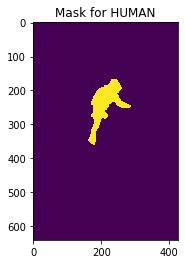

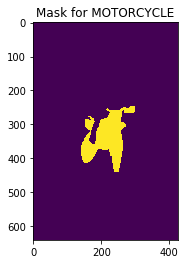

In [9]:
labels = kili.labels(project_id=project_id,
                           asset_external_id_in=[external_id],
                           fields=['jsonResponse'])
json_response = labels[-1]['jsonResponse']

polygons = kili_to_cv(json_response, shape)

for category in ['HUMAN', 'MOTORCYCLE']:
    mask = np.zeros(shape)
    if category not in polygons:
        continue
    cv2.fillPoly(mask, np.array(polygons[category], dtype=np.int32), 1)
    plt.figure()
    plt.title(f'Mask for {category}')
    plt.imshow(mask)
    mask_image = Image.fromarray(mask*255).convert('L')
    mask_image.save(f'{category}.mask.png')